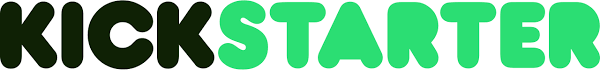
<br>
<hr style="border-width:2px;border-color:limegreen">
<center><h1>Projet Pyckstarter</h1></center>
<center><h2>Votre campagne a-t-elle des chances de succès ?</h2></center>
<hr style="border-width:2px;border-color:limegreen">
<center>Bootcamp - Data analyst - Mars 2021 <br></center>
<center>Théo Bardon, Paul Choï-Monges, Quentin Declercq & Ségolène Truffert</center>


<br>

# Préparation du dataset
<hr style="border-width:2px;border-color:limegreen">

>L’objectif de notre étude est de déterminer les éléments qui contribuent au succès d’une levée de fonds sur Kickstarter.<br>
En nous basant sur les données du site, nous souhaitons être une aide à la décision en déterminant les choix qui conduisent au succès.<br><br>
Pour parvenir à cet objectif, nous avons récolté des informations sur le site **webrobots.io** ; ce site propose une copie complète du site Kickstarter par mois. <br><br>
Sur la dernière sauvegarde disponible, au mois de Mars 2021, nous avons un jeu de données décomposé en 50 parties. <br>
La première tâche du projet fut donc de compiler ces données afin d’obtenir une première version exploitable, Kick_merge_1. Pour cela nous avons mis en place des fonctions pour fusionner les fichiers et vérifier la qualité des données.<br>
Nous avons procédé à une première analyse de nos données et effectué les premiers nettoyages :
>- Suppression des valeurs manquantes avec dropna()
>- Suppression des doublons du à la fusion
>- Passer la colonne ID en index
>
>Après ce nettoyage, nous avons créé un nouveau DataFrame nommé Kick_Merge, grâce aux données contenues dans les Json. <br>
Kick_Merge contient un nombre important de données inutiles d’un point de vue analytique (par exemple symbole des devises : € & $).
>Le travail préparatoire que nous avons réalisé est disponible dans le dossier source <a href="./Création DataFrame.ipynb">ici</a>.

>Pour la suite de l'analyse nous avons décidé de garder 17 variables. Certaines ont été créées par des fonctions personnalisées et d'autres sont issues du dataframe originel. <br> 
Nous avons aussi nettoyé les données pour la suite de l'analyse :
>- Renommer des variables pour une meilleure compréhension,
>- Nettoyage de la variable target. Notre variable target "state" comporte 4 modalités : "successful / failed /live /cancelled". 
Pour faciliter le traitement des données, nous décidons de supprimer les projets "live" et d'intégrer les projets "cancelled" aux projets "failed".
>
>
>Nos travaux de nettoyage sont disponibles ci-dessous.
>
>Après ces premiers retraitements, nous disposons d'un DataFrame sur lequel nous pouvons débuter notre analyse.


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from wordcloud import WordCloud
from PIL import Image
import time
import warnings
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import model_selection
from sklearn import preprocessing
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('./Kick_Merge.csv', index_col = 'id', compression='bz2')

In [3]:
df = df[['backers_count', 'blurb', 'country','type_location','id_creator', 'deadline', 'parent_name_cat','slug_cat','duration_launch_dead_d_e', 'created_at','launched_at_y', 'launched_at_m','launched_at_h','goal_usd', 'state']]

In [4]:
#Créer d'une nouvelle variable
df['blurb_length'] = df['blurb'].apply(lambda x : len(x))

# Définition de blurb_nb_car
df['blurb_nb_car'] = pd.cut(df['blurb'].apply(lambda x : len(x)), bins=[1., 20., 40., 80., 100., 120., 140., 160.])

#Renommer les variables 
df.rename(columns = {'parent_name_cat':'main_cat'}, inplace = True)
df.rename(columns = {'duration_launch_dead_d_e':'duration'}, inplace = True)
df.rename(columns = {'slug_cat':'sub_cat'}, inplace = True)

#Nettoyer la variable "state"
df = df[df['state']!='live']
df['state'] = df['state'].replace({'canceled' : 'failed'}).astype(object)

#Supprimer les projets avec un goal en dessous de 100$
df = df[df['goal_usd']>=100]

# Supprimer les NA
df = df.dropna()

In [5]:
df.shape

(171882, 17)

In [6]:
df.head()

,backers_count,blurb,country,type_location,id_creator,deadline,main_cat,sub_cat,duration,created_at,launched_at_y,launched_at_m,launched_at_h,goal_usd,state,blurb_length,blurb_nb_car
id,,,,,,,,,,,,,,,,,
123246984,4,"Soaps made with love, care, creativity and you...",US,Town,5.130037e+08,1515102534,Crafts,crafts/diy,30,1512430228,2017,12,21,150.0,failed,82,"(80.0, 100.0]"
1207132794,35,"Pens made from Whiskey barrels, Jack Daniel's ...",US,Town,2.022067e+09,1531325825,Crafts,crafts/woodworking,30,1528377129,2018,6,16,900.0,successful,84,"(80.0, 100.0]"
1899686686,310,Finally we have a building but we need your he...,US,Town,9.889741e+08,1447620375,Dance,dance/spaces,45,1443014021,2015,10,19,8500.0,successful,124,"(120.0, 140.0]"
1081353908,1,Everything home made in one store. From jewelr...,US,Town,1.794354e+09,1415406440,Crafts,crafts/diy,30,1412436646,2014,10,23,50000.0,failed,132,"(120.0, 140.0]"
84306631,36,"Growing My Natural, Eco-Friendly, and Fun Bath...",US,Town,1.149297e+09,1602385860,Crafts,crafts/candles,25,1599615992,2020,9,5,800.0,successful,55,"(40.0, 80.0]"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171882 entries, 123246984 to 1661976032
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   backers_count  171882 non-null  int64   
 1   blurb          171882 non-null  object  
 2   country        171882 non-null  object  
 3   type_location  171882 non-null  object  
 4   id_creator     171882 non-null  float64 
 5   deadline       171882 non-null  int64   
 6   main_cat       171882 non-null  object  
 7   sub_cat        171882 non-null  object  
 8   duration       171882 non-null  int64   
 9   created_at     171882 non-null  int64   
 10  launched_at_y  171882 non-null  int64   
 11  launched_at_m  171882 non-null  int64   
 12  launched_at_h  171882 non-null  int64   
 13  goal_usd       171882 non-null  float64 
 14  state          171882 non-null  object  
 15  blurb_length   171882 non-null  int64   
 16  blurb_nb_car   171882 non-null  category
dty

# Description Statistique
<hr style="border-width:2px;border-color:limegreen">



In [8]:
def color_function(df = df, pal = 'sns', category = None):

  '''

  La fonction permet de choisir la couleur à appliquer au graphique : Par défaut les couleurs automatiques seaborn
  
  '''

  # Pour infos :

  # https://matplotlib.org/stable/tutorials/colors/colormaps.html
  # https://seaborn.pydata.org/tutorial/color_palettes.html

  if pal == 'sns' :
    return sns.color_palette()
  elif pal == 'rainbow' :
    return cm.rainbow(np.linspace(0.1,0.8,df[category].nunique()))
  elif pal == 'jet' :
    return cm.jet(np.linspace(0.1,0.8,df[category].nunique()))
  elif pal == 'CMRmap' :
    return cm.CMRmap(np.linspace(0.1,0.8,df[category].nunique()))
  elif pal == 'viridis' :
    return cm.viridis(np.linspace(0.1,0.8,df[category].nunique()))
  elif pal == 'gist_rainbow' :
    return cm.gist_rainbow(np.linspace(0.1,0.8,df[category].nunique()))
  else :
    return pal

   ### 1. Nombre de projets lancés par an

>Ce graphique nous permet d'étudier l’évolution globale des projets. Grâce à celui-ci, nous pouvons constater la proportion des projets kickstarters réussis et échoués depuis 2009. 
>
>Après un pic en 2015, le nombre de projets lancés s’est stabilisé autour de 19 000 par an. Dans le même temps, le nombre de projets échoués diminue passant de 10 000 en 2017 à 6 000 en 2020.


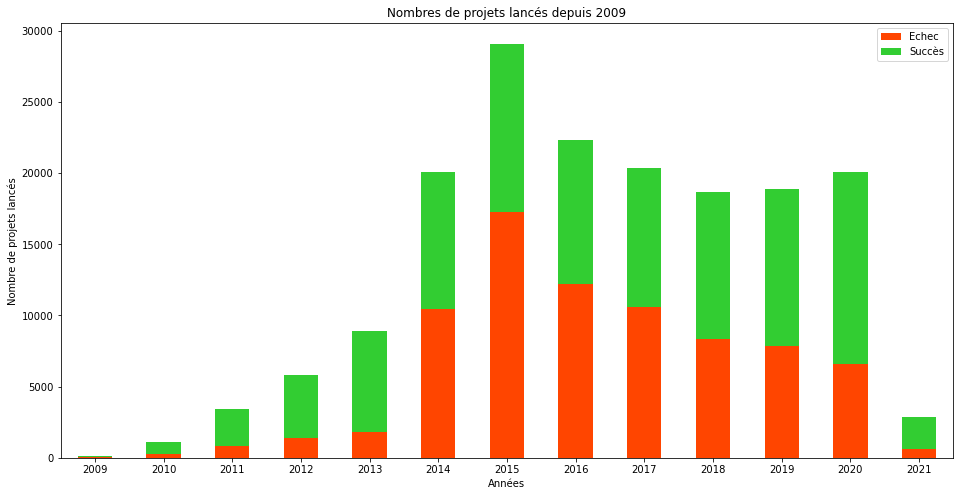

In [9]:
ct = pd.crosstab(df['launched_at_y'], df['state'])
ax = ct.plot(kind='bar', stacked=True, figsize=(16,8), rot =0, color =['orangered', 'limegreen'])

plt.xlabel ('Années') 
plt.ylabel('Nombre de projets lancés')
plt.legend(['Echec','Succès'])
plt.title('Nombres de projets lancés depuis 2009')
plt.savefig('mon_graphique')

### 2. Analyse par pays

>La fonction suivante permet de représenter la proportion de chaque pays dans le lancement des projets.

In [10]:
def graph_area_chart(normalize = 0, top = 100, year = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], size = (16,9), state = ['successful', 'failed'], alpha=0.85, pal = 'sns'):
  # Construction de la matrice année_création // Pays
  df_project = pd.crosstab(df['launched_at_y'][(df['launched_at_y'].isin(year)) & (df['state'].isin(state))], df['country'][(df['launched_at_y'].isin(year)) & (df['state'].isin(state))], normalize = normalize)

  # Construction d'une liste des top pays
  top_country = df_project.sum().sort_values(ascending = False)

  # Liste des pays à supprimer
  tail_country = top_country[top:].index

  # Pays autres
  other_country = top_country[top:].sum()

  # Suppression de la liste des top pays
  top_country = top_country[:top]
  top_country['Autre'] = other_country

  # Sélection des top pays et création de variable 'Autre'
  df_project['Autre'] = df_project[tail_country].sum(axis=1)
  df_project = df_project[top_country.index]

  # Suppression des pays non présents dans le top
  df_project.drop(columns=top_country[top+1:].index, inplace = True)

  # Création du graphique
 
  color = color_function(df = df, pal = pal, category = 'country')

  plt.figure(figsize=size)
  plt.stackplot(df_project.index, [df_project[x] for x in df_project.columns], labels = df_project.columns, colors = color, alpha=alpha)
  plt.legend(loc=2, fontsize='large')
  plt.show();

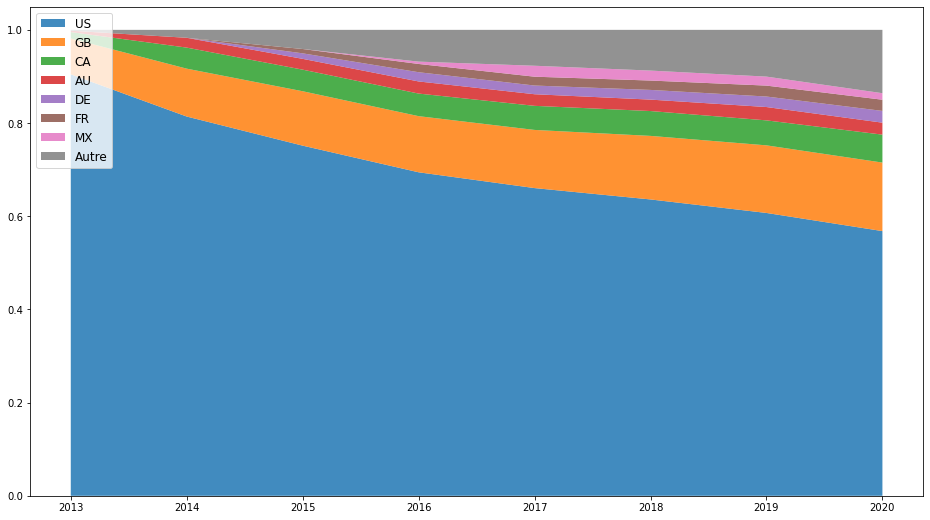

In [11]:
graph_area_chart(top=7, state = ['successful'])

> Sans surprise, les Etats-Unis sont les plus gros contributeurs, même si nous voyons une très légère baisse au profit de la Grande-Bretagne et les classés dans la catégorie "Autre".

### 3. L'expérience du créateur

>Grâce à ce graphique, nous souhaitons savoir si l'expérience des créateurs influence la réussite d'un projet. Pour cela nous avons utilisé la variable id_creator. La fonction suivante nous montre que pour un premier projet, il y a 50% de chance d'échec. Cependant, dès le 2ème projet nous constatons un taux de réussite de 80%.<br><br>
L'expérience des créateurs (connaissance et expérience sur la plateforme) leur permet d'assurer une meilleure chance de réussite.<br><br>
⚠️ Il est aussi important de noter que très peu de créateurs ont lancé plus de 10 projets. C'est pour cela que nous notons d'importantes fluctuations sur la partie droite du graphique.

In [12]:
def success_n_project(df=df, tab = 'graph', size = (16,9), state = ['successful', 'failed'], normalize = 1, top = 60):
    df_crea = df[['id_creator', 'created_at', 'state']][df['state'].isin(state)].sort_values(by = ['id_creator', 'created_at']).reset_index().drop('id', axis = 1)
    
    df_crea['N_Projet'] = 0
  
    for n in df_crea.index:
        if df_crea.iloc[n,0] == df_crea.iloc[n-1,0]:
            df_crea.iloc[n,3] = df_crea.iloc[n-1,3] + 1
    else:
        df_crea.iloc[n,3] = 1

    success_n_project = pd.crosstab(df_crea.state, df_crea.N_Projet, normalize = normalize).transpose()[:top]

    if tab == 'line':
        fig, ax = plt.subplots(1, 1, figsize=size)
        return success_n_project.plot(kind = 'line', ax =ax, color =['orangered', 'limegreen'])
    if tab == 'bar':
        fig, ax = plt.subplots(1, 1, figsize=size)
        return success_n_project.plot(kind = 'bar', ax =ax, color =['orangered', 'limegreen'])
    elif tab == 'tab':
        return success_n_project

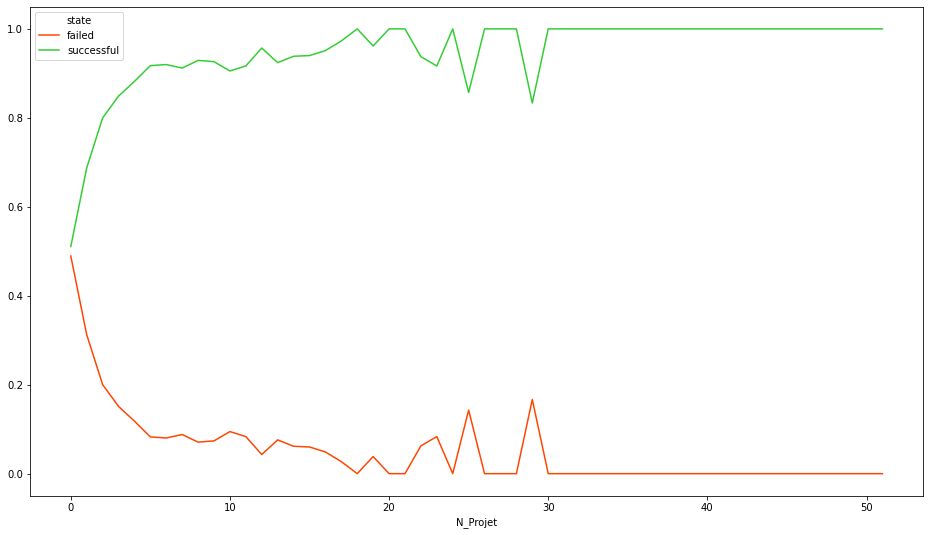

In [13]:
success_n_project(tab = 'line', state = ['successful', 'failed']);

## Taux de réussite

### 1. Selon la catégorie

>La fonction ci-dessous permet d'analyser le taux de réussite d'un projet selon le type du projet (en valeur absolue et en pourcentage).


In [14]:
def graph_bar_success_bis(df=df, year = 'all', state = ['successful', 'failed'], colomns = 'launched_at_y', subject = 'country', size=(25,12), normalize = 0, axe = 'h', alpha = 0.85, annotate = 'on', opt = False):
  '''

  Fonction similaire à graph_bar_success_bis

  Permet des possibilitées en plus : 
  
  -> axe : Modifier sens du graphique
  -> annotate : Affichage ou non des annotations
  -> normalize : Normalisation des données ou non
  -> alpha : Transparence des couleurs
  -> opt : True si problème affichage

  '''
  def affichage(axe = axe, normalize = normalize):
      for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds

        if axe == 'h' and normalize is 0:
          ax.annotate(str(round((width)*100,1)) + ' %', xy=(left+width/2, bottom+height/2), ha='center', va='center')
        elif axe == 'h' and normalize is not 0:
          ax.annotate(str(int(width)), xy=(left+width/2, bottom+height/2), ha='center', va='center')
        elif axe == 'v' and normalize is 0:
          ax.annotate(str(round((height)*100,1)) + ' %', xy=(left+width/2, bottom+height/2), ha='center', va='center')
        elif axe == 'v' and normalize is not 0:
          ax.annotate(str(int(height)), xy=(left+width/2, bottom+height/2), ha='center', va='center')

      ax.set_title('Part de succès des projets selon ' + str(subject) + ' - ' + str(year))

  if year == 'all':
    tab = pd.crosstab(df[subject], df.state, normalize=normalize).sort_values(by = 'successful', ascending = True)
  elif year == list:
    tab = pd.crosstab(df[df[colomns] in year][subject], df[df[colomns] in year].state, normalize=normalize).sort_values(by = 'successful', ascending = True)
  else:
    tab = pd.crosstab(df[df[colomns] == year][subject], df[df[colomns] == year].state, normalize=normalize).sort_values(by = 'successful', ascending = True)

  tab.sort_values(by = 'successful', ascending = True)


  # Si non normalisation, trie selon nombre de projets
  if normalize is not 0:
    tab['Total'] = tab.sum(axis = 1)
    tab = tab.sort_values(by='Total', ascending = False).drop('Total', axis = 1)

  if opt is True:
    tab = tab.sort_values(by=subject, ascending = True)

  # Si axe horizontal
  if axe == 'h':
    ax = tab.plot.barh(y=state, stacked = True, figsize=size, width = 0.75, color = {'successful' : 'limegreen', 'failed' : 'orangered'}, alpha = alpha)
    if annotate == 'on':
      affichage(axe, normalize)

  # Si axe vertical
  elif axe == 'v':
    ax = tab.plot.bar(y=state, stacked = True, figsize=size, color = {'successful' : 'limegreen', 'failed' : 'orangered'}, alpha = alpha)
    if annotate == 'on':
      affichage(axe, normalize)

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-14-abee9f9df2dd>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if axe == 'h' and normalize is 0:
<ipython-input-14-abee9f9df2dd>:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  elif axe == 'h' and normalize is not 0:
<ipython-input-14-abee9f9df2dd>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
 

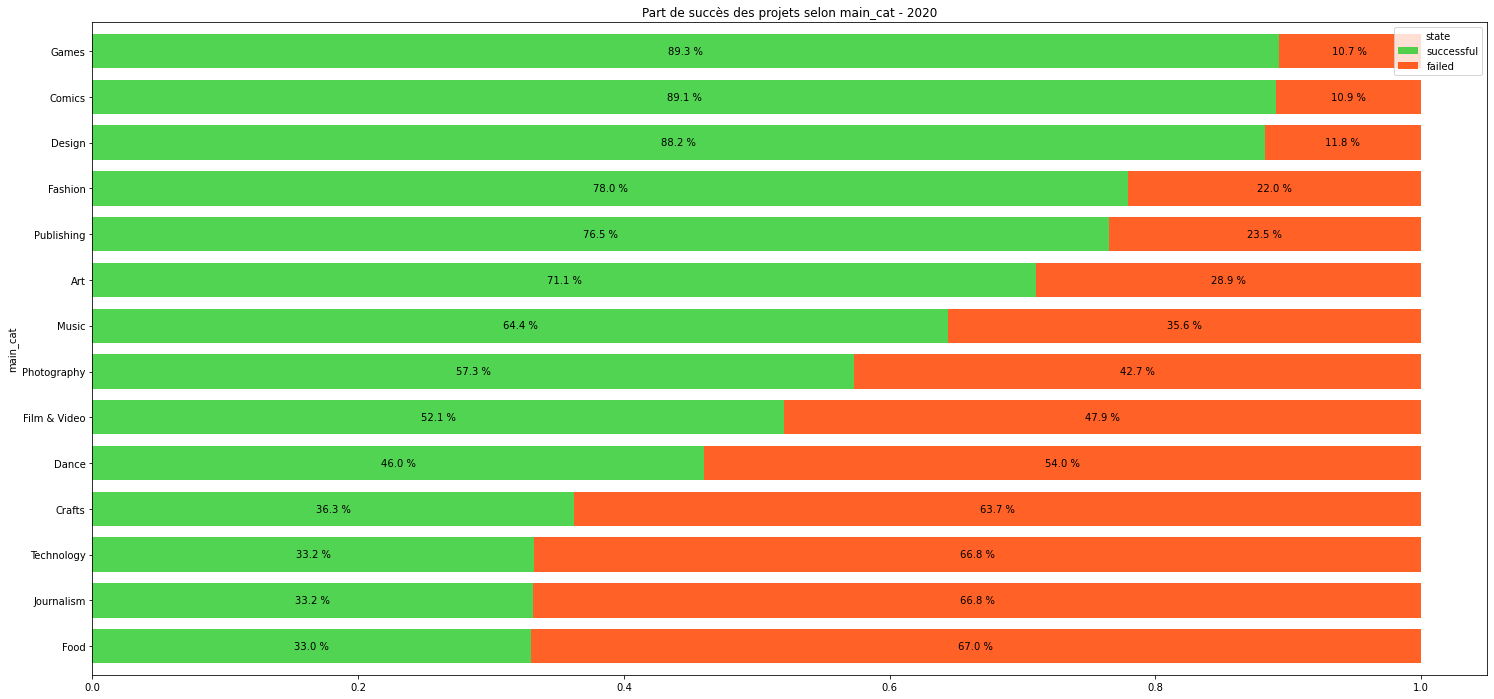

In [15]:
graph_bar_success_bis(normalize = 0, state = ['successful', 'failed'], axe = 'h', annotate='on', year = 2020, subject = 'main_cat')

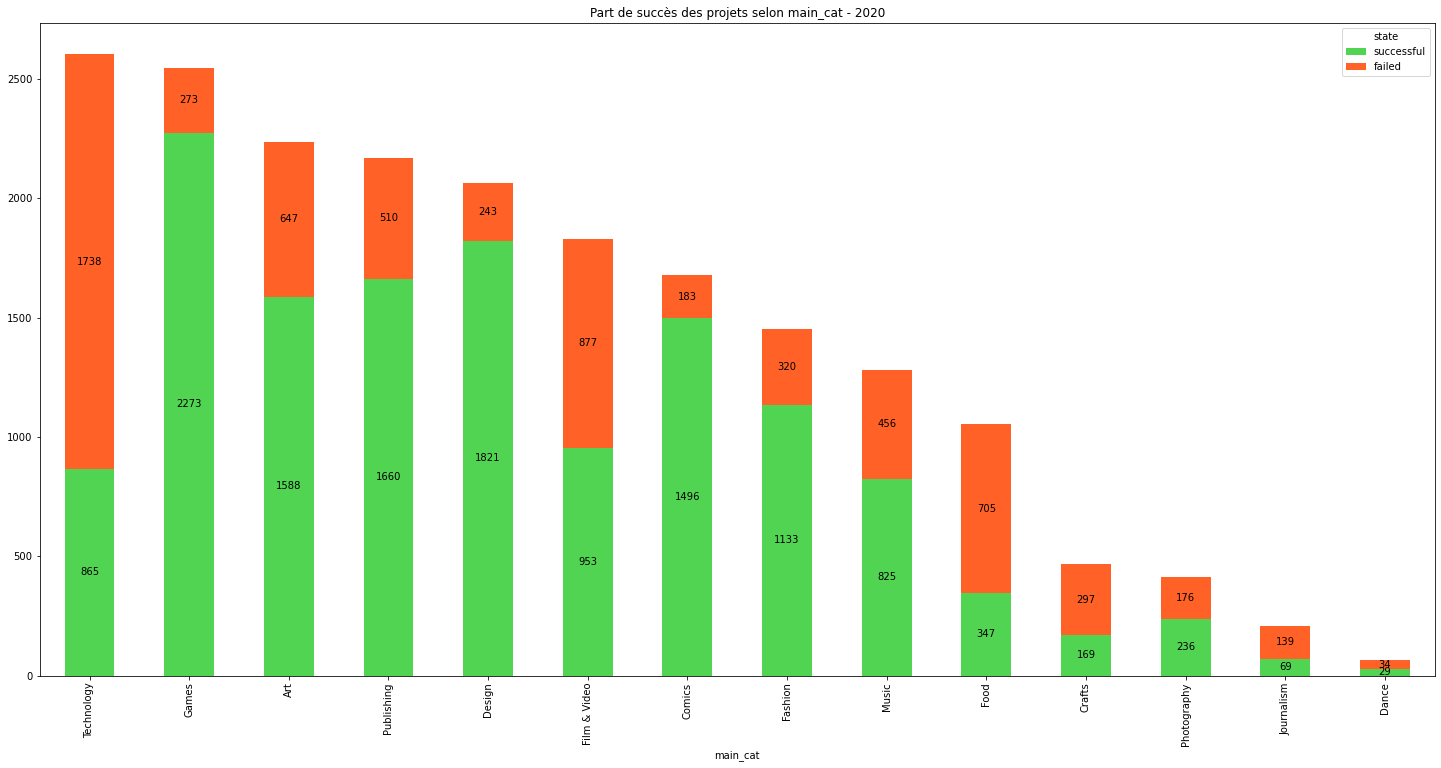

In [16]:
graph_bar_success_bis(normalize = False, state = ['successful', 'failed'], axe = 'v', annotate='on', year = 2020, subject = 'main_cat')

>Nous pouvons observer qu'en 2020 les catégories "Jeux", "Comics" et "Design" sont celles qui fonctionnent davantage. Ces 3 catégories ont presque 90% de réussite.
La catégorie "Jeux", en plus d'avoir de très bon taux de réussite en 2020, est aussi la deuxième catégorie la plus importante en volume. A l'inverse, la catégorie "Technologie" possède un des taux d'échec les plus importants sur l'année 2020. Les autres catégories les moins efficaces sont "Journalisme" et "Food".

### 2. Selon le mois de lancement

>La fonction ci-dessous permet d'analyser le taux de réussite d'un projet selon son mois de lancement.

In [17]:
def success_startmonth(year = 'all', type_date = 'launched_at_m' , filter_col = None, filter = None, pal = 'sns'):

  if filter_col != None:
    base_filter = df[['state', type_date, filter_col]]
  elif filter_col == None:
    base_filter = df[['state', type_date]]

  if year != 'all':
    base_filter = df[['state', type_date, filter_col]][df[type_date] == year]

  if filter_col != None and filter != None:
    base_filter = base_filter[['state', type_date, filter_col]][base_filter[filter_col] == filter]

  base_filter = pd.crosstab(base_filter['state'], base_filter[type_date], normalize = 1).transpose()
  base_filter = base_filter.rename(index={1: "Jan", 2: "Fev", 3 : "Mar", 4 : "Avr",  5: "Mai", 6 : "Joi", 7 : "Jui", 8: "Aou", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec" })

  fig, ax = plt.subplots(1, 1, figsize = (16,9))

  color = color_function(df = df, pal = pal, category = type_date)

  base_filter.successful.plot(kind = 'bar', color = color, ax=ax)

  ax.set_title('Succès selon le mois de lancement')
  ax.set_ylabel('% Succès')
  ax.set_xlabel('Mois de lancement');

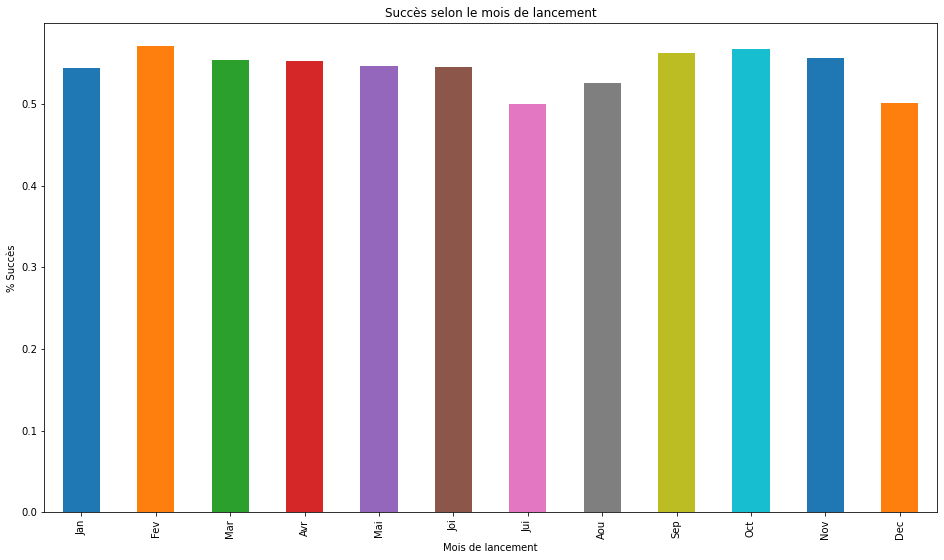

In [18]:
success_startmonth(pal = 'sns')

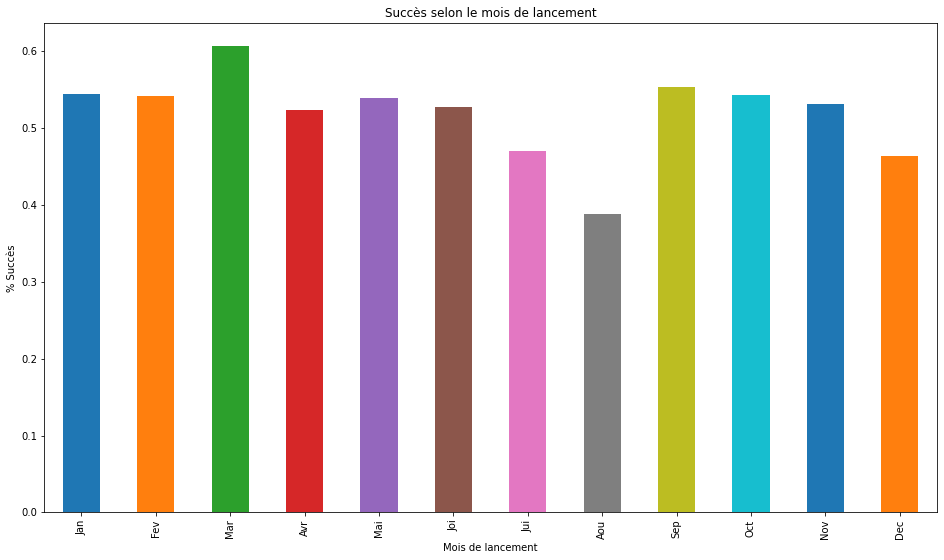

In [19]:
success_startmonth(filter_col = 'country', filter = 'FR')

>L'analyse par mois est relativement stable (+/- 0.5 pt) mais nous notons que les mois de Juillet et Décembre ne sont pas propices au lancement de projets sur la plateforme. 
>
>Si nous décidons de nous focaliser sur la France, nous voyons une plus grande disparité. Le mois de Mars est le meilleur mois pour lancer un projet. A l'inverse, le mois d'Août n'est pas recommandé.

### 3. Selon la longueur de la description

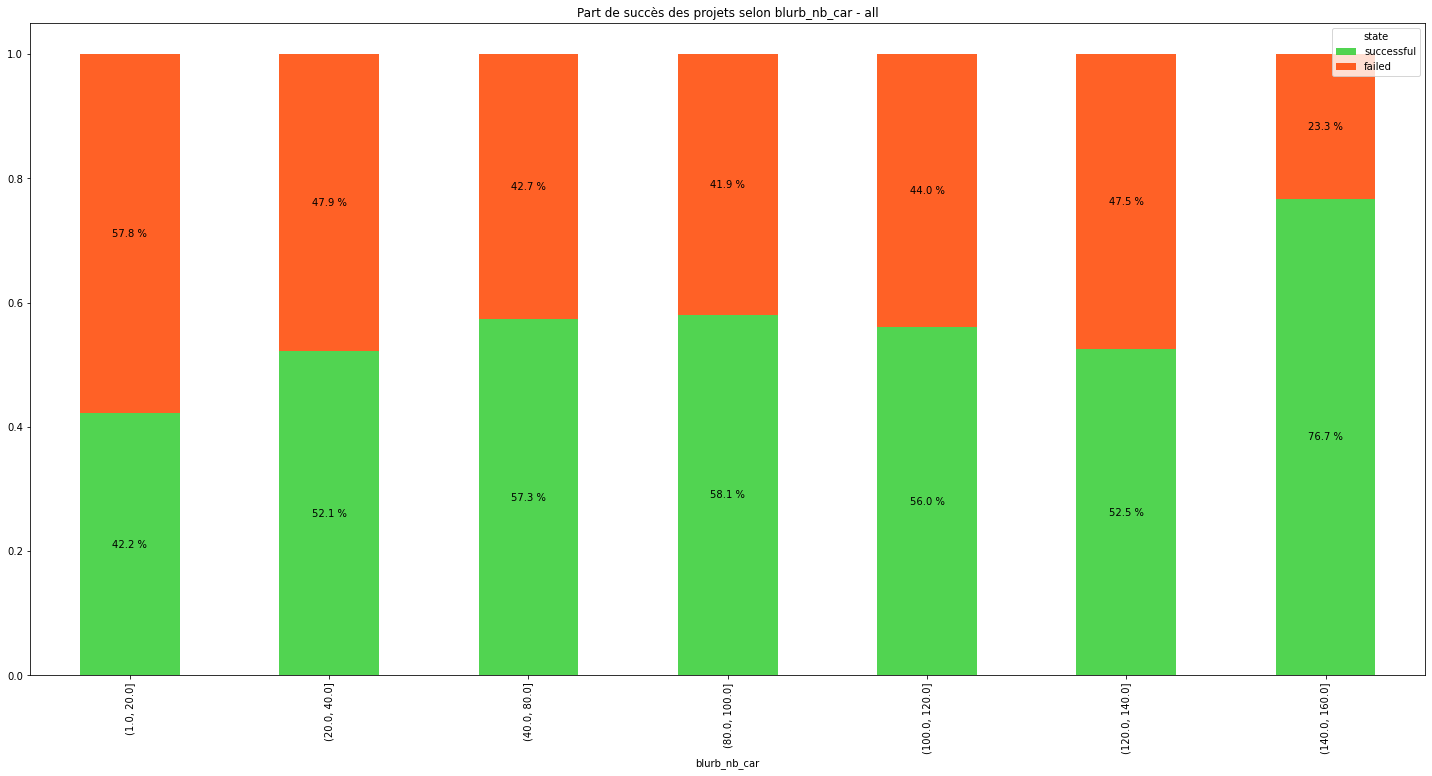

In [20]:
graph_bar_success_bis(normalize = 0, axe = 'v', annotate='on', subject = 'blurb_nb_car', opt= True)

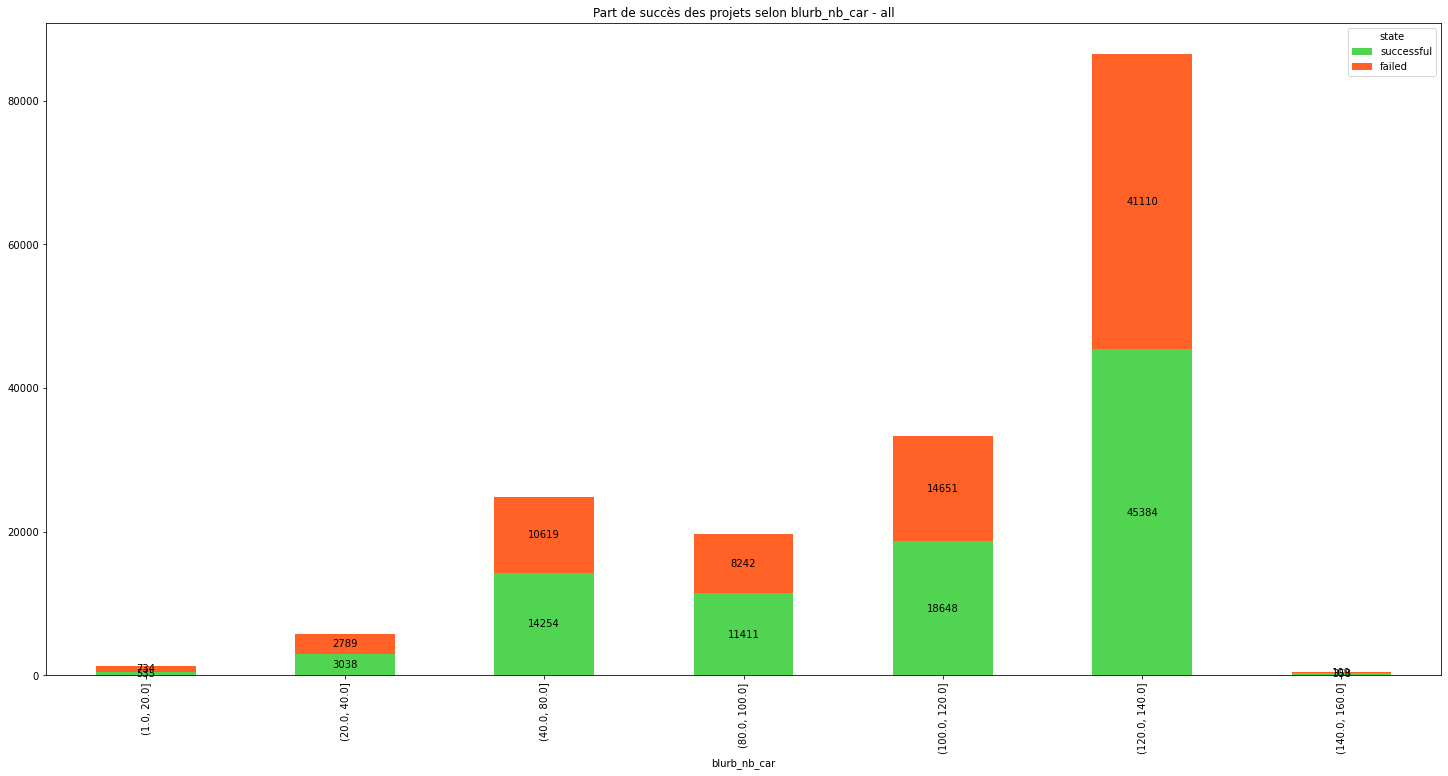

In [21]:
graph_bar_success_bis(normalize = False, axe = 'v', annotate='on', subject = 'blurb_nb_car', opt= True)

> Une description exhaustive permet-elle de favoriser la réussite d'un projet ? 
Grâce aux graphiques ci-dessous, nous pouvons remarquer qu'il faut au minimum 40 caractères pour avoir un taux de réussite supérieur à 50%. 
Une description plus longue (entre 140-160 caractères) est corrélée à une meilleure réussite.
Cependant, il semble que la plateforme Kickstarter ait mis en place une limitation de caractères pour la description des projets car aucune description n'excède les 160 caractères. Pour une meilleure analyse, il faudrait pouvoir analyser la description longue (nous n'y avons pas accès, ici). 

# Wordcloud
<hr style="border-width:2px;border-color:limegreen">

In [22]:
#!pip install wordcloud
#!pip install stop-words
#!pip install nltk

import nltk

nltk.download('stopwords')

#### Initialisation de la variable text ####
text = ""
for resume in df.blurb : 
    text += resume
    
#### Tokenisation ####
from nltk.corpus import stopwords

#### retrait des mots communs ####
stop_words = set(stopwords.words('english'))
print(stop_words)

#### ajout de mots communs ####
mots_vides=['new','help','game','set','EP','us','series','serie','get','time','need','life','make','one','on','get','pin','de','project','film','music','art','music','and','in','from','s','u','with','we','have','a','but','your','to','are','who','i','my','the','into','be',
              ',','.','"','of','all','is','the','are','!','by','-','for','&','....','that','ve','you','has','on','at','so',
              'our','ll','(',')','an','as','m','my','with','that','about']
            
stop_words.update(mots_vides)

######################################################
#### Séparation du texte selon succès ou échec####

df.state = df.state.replace(['successful', 'failed'], [1,0])

df_pos = df[df.state == 1]
df_neg = df[df.state == 0]

### creation des listes pos/neg text
pos_text = ""
for e in df_pos.blurb :
    pos_text += e
   
    
neg_text = ""
for e in df_neg.blurb :
    neg_text += e
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Théo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'d', 'won', 'she', 'here', 'but', 'what', "shouldn't", 'only', 'an', 'her', 'with', 'wouldn', 'be', "couldn't", 'from', 'ourselves', 'y', "hadn't", 'between', 'a', 'own', 'all', 'any', 'his', 'needn', 'under', "wouldn't", 'whom', 'and', 'ma', 'ours', 'been', 'off', 'its', 'just', "mightn't", 'you', 'itself', "isn't", 'had', "you're", 'for', 'ain', 'very', 'because', 'hadn', 'by', 'doing', 'again', 'or', 'isn', 'my', 'wasn', 'over', 'will', 'through', 'theirs', 'mightn', 's', 'our', 'yours', "you'd", "that'll", 'he', 'where', "haven't", 'once', 'themselves', 'the', "doesn't", 'after', 'this', "she's", 'than', 'how', 'few', 'at', 'have', 'am', 'don', 'that', "didn't", 'about', 'up', "should've", 'before', 'other', "aren't", 'yourselves', "weren't", 'didn', 'll', 'does', 'above', 'during', 'most', "you've", 'those', 'then', 'why', 've', 'me', 'your', 'there', "shan't", 'should', 'doesn', 'i', 'they', "mustn't", "hasn't", 'more', 'which', 'against', 'hers', 'too', 'o', 'haven', 'if', 'sho

Après un travail préparatoire, nous avons pu extraire deux nuages de mots : un pour les projets qui ont réussi, un autre pour les projets qui ont échoué. <br>                                                                            Ici, nous remarquons que les mots mis en avant sont très similaires : "word", "book", "first".

>###  Nuage de mots à succès

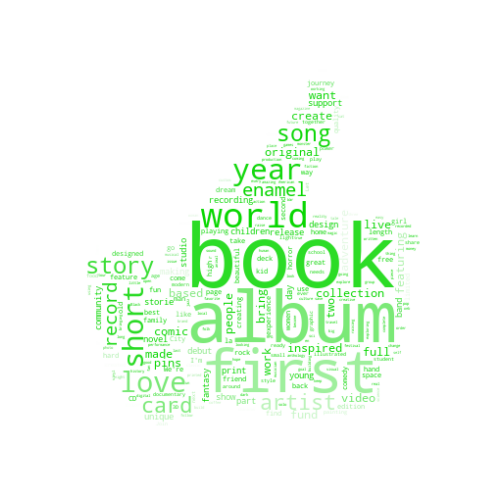

In [23]:
from PIL import Image
import numpy as np
from wordcloud import ImageColorGenerator

#### création des masques ####
mask_s = np.array(Image.open("success.jpg"))
mask_f = np.array(Image.open("failed.jpg"))

#### images wordcloud ####
wc = WordCloud(background_color="white", max_words=1000,stopwords= stop_words, max_font_size=90, collocations= False, mask = mask_s, random_state=42)
wc.generate(pos_text)

img_color = ImageColorGenerator(mask_s)

wc.recolor(color_func = img_color)

plt.figure(figsize= (16,9)) 
plt.axis('off')
plt.imshow(wc, interpolation='bilinear') 
plt.show()

>###  Nuage de mots à échec

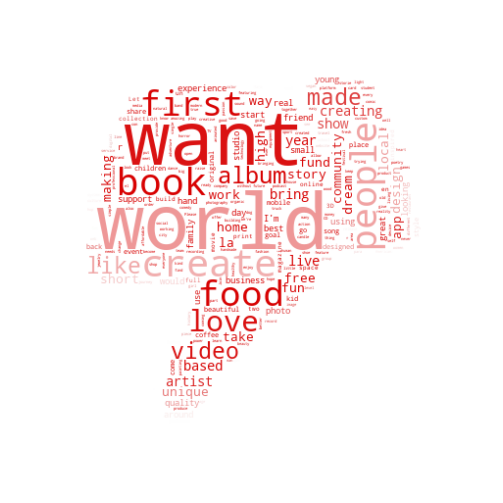

In [24]:
wc = WordCloud(background_color="white", max_words=1000,stopwords= stop_words, max_font_size=90, collocations= False, mask = mask_f, random_state=42)
wc.generate(neg_text)

img_color = ImageColorGenerator(mask_f)

wc.recolor(color_func = img_color)

plt.figure(figsize= (16,9)) 
plt.axis('off')
plt.imshow(wc, interpolation='bilinear') 
plt.show()

<br>

# Machine Learning
<hr style="border-width:2px;border-color:limegreen">

>Pour nos expérimentations de Machine Learning, nous avons décidé de tester 13 méthodes de **classification**. Ici, nous en développerons 3 :
>- <span style='color:limegreen'> **Random Forest**</span>
>- <span style='color:limegreen'>**KNeighbors**</span>
>- <span style='color:limegreen'>**Cat Boost**</span>
>
>Pour cette analyse nous allons utiliser les variables **features** choisies au début de notre analyse pour prédire notre variable target : "**state**".

## 1. Pre-processing

>Pour préparer notre jeu de données, nous avons effectué plusieurs travaux de pre-processing : 
>
>- Modifier les modalités de la variable target : "Successful" en 1 et "Failed" en 0, 
>- Créer des variables indicatrices,
>- Séparer les données en 2 dataframes pour séparer les données explicatives de la varible cible,
>- Séparer en deux jeux de données : test et train,
>- Normaliser des données.
>
>Avant de lancer les différentes méthodes de Machine Learning, nous avons analysé l'état de notre dataframe.<br>
Nous pouvons remarquer que notre dataframe est plutôt équitable. En effet, il n'y a de différence notoire entre le nombre de projets qui ont été validés et ceux abandonnés. 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


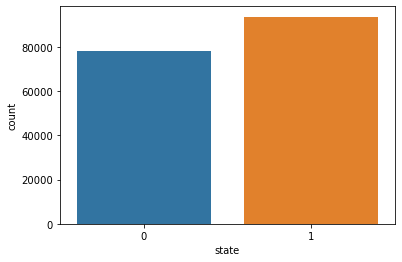

In [25]:
sns.countplot(df.state);

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Modèles de classification que l'on va utiliser
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import model_selection
from sklearn import preprocessing

# Pour évaluer nos modèles
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

# Décomposition
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

In [27]:
df = df[['blurb_length','country','type_location', 'main_cat','sub_cat','duration','launched_at_y', 'launched_at_m', 'goal_usd', 'state']]

df['launched_at_m'] = df['launched_at_m'].astype('object')
df['launched_at_y'] = df['launched_at_y'].astype('object')

df_dummies = pd.get_dummies(df)
df_dummies.head()

X = df_dummies.drop('state', axis=1)
y = df_dummies['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=44)

scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

<ipython-input-27-b134bbf42fde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['launched_at_m'] = df['launched_at_m'].astype('object')
<ipython-input-27-b134bbf42fde>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['launched_at_y'] = df['launched_at_y'].astype('object')


## 2. Modèles de Machine learning

### KNeighbors Classifier (KNN)

>Le premier modèle que nous avons testé est le modèle **KNeighborsClassifier**. Celui-ci propose un score de 0,74. Pour un premier modèle testé, celui-ci semble être satisfaisant. Attention toutefois; le temps de traitement est relativement long (+/- 20 minutes). 
>Pour les prochains modèles, nous souhaitions améliorer **l'accuracy et optimiser les temps de calcul**. 

In [28]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)
clf_knn.fit(X_train_scaled, y_train)

y_pred_train = clf_knn.predict(X_train_scaled)
y_pred_test = clf_knn.predict(X_test_scaled)

print("Accuracy on test set : {}".format(clf_knn.score(X_test_scaled, y_test)))

Accuracy on test set : 0.7427166814539002


In [29]:
data_crosstab = pd.crosstab(y_test, y_pred_test)

print(data_crosstab)

col_0      0      1
state              
0      48414  14235
1      21143  53714


### Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
model  = RandomForestClassifier(n_estimators = 50, random_state = 123)
print('Train set:', X_train.shape)
print('Test set', X_test.shape)

Train set: (34376, 225)
Test set (137506, 225)


In [31]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

print("Accuracy on training set : {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set : {:.3f}".format(model.score(X_test, y_test)))

Accuracy on training set : 1.000
Accuracy on test set : 0.780


In [32]:
y_pred = model.predict(X_test)
pd.crosstab(y_test, y_pred, rownames = ['Classe réelle'], colnames = ['Classe prédite'], normalize = True)

Classe prédite,0,1
Classe réelle,,
0,0.375955,0.079655
1,0.140474,0.403917


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.83      0.77     62649
           1       0.84      0.74      0.79     74857

    accuracy                           0.78    137506
   macro avg       0.78      0.78      0.78    137506
weighted avg       0.79      0.78      0.78    137506



In [34]:
model.feature_importances_

array([9.09108199e-02, 8.23141492e-02, 1.34343086e-01, 7.07859205e-04,
       3.04376345e-03, 7.21803023e-04, 5.09661009e-03, 7.08087395e-04,
       2.42705816e-03, 9.31488735e-04, 1.80438292e-03, 2.26907133e-03,
       8.14043420e-03, 3.58820898e-05, 1.15494482e-03, 6.76811839e-04,
       2.16387005e-03, 6.25717858e-04, 8.39787004e-05, 2.57452818e-03,
       1.49853607e-03, 6.69788678e-04, 7.58314648e-04, 3.14093800e-06,
       1.60073037e-03, 8.55725219e-04, 2.70592290e-06, 1.18954253e-02,
       6.23486798e-05, 4.47969088e-03, 0.00000000e+00, 2.13382385e-04,
       1.14666410e-03, 2.28266274e-05, 2.82513641e-03, 5.93026938e-03,
       5.44908701e-04, 4.90567422e-03, 1.08689633e-02, 7.71104982e-03,
       1.64504747e-03, 3.86470511e-03, 4.04325958e-03, 6.11240373e-03,
       1.17407999e-02, 5.70394729e-03, 4.81191689e-03, 6.34516410e-03,
       4.02586476e-03, 5.94401119e-03, 5.68421053e-03, 9.41679250e-04,
       1.91756776e-03, 2.91602562e-03, 9.02785420e-03, 1.01268404e-03,
      

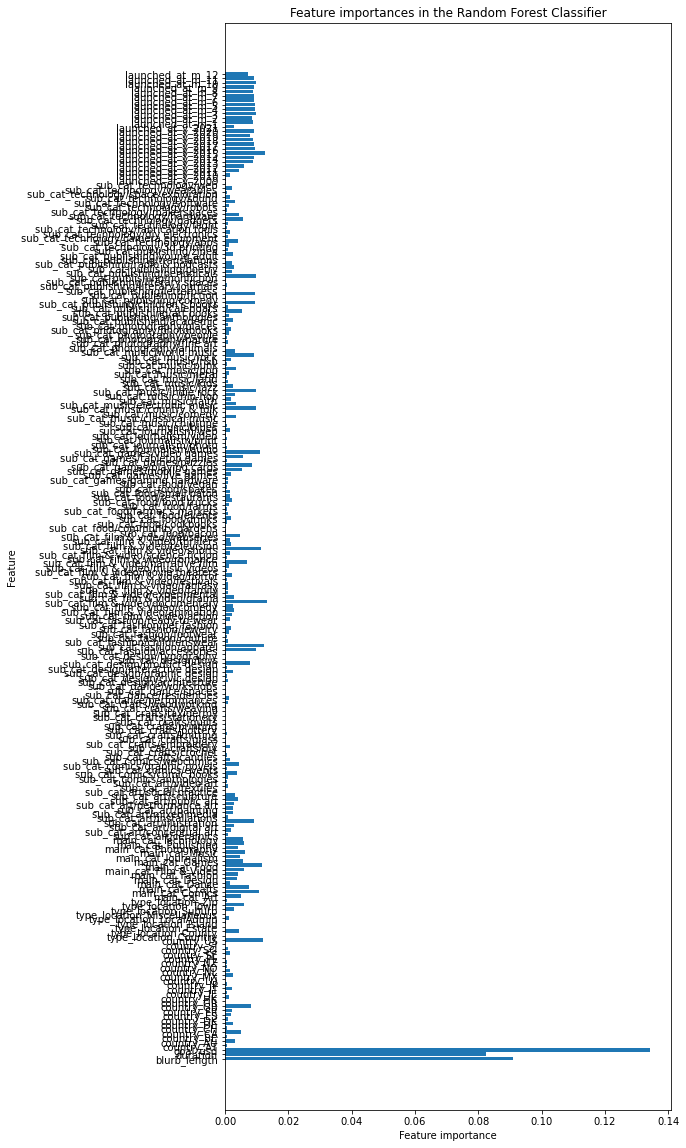

In [35]:
n_features = X_train.shape[1]
plt.figure(figsize=(8,20))
plt.barh(range(n_features), model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.title("Feature importances in the Random Forest Classifier")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

> Plusieurs propriétés sont utiles pour résumer le fonctionnement de l'arbre. La plus courante est l'importance des caractéristiques (ou variables = features importances). <br>
> Cette dernière mesure l'importance de chacune des caractéristiques dans la décision (valeur comprise entre 0 et 1).
La valeur 0 signifie que la variable n'est pas du tout utilisée alors que la valeur 1 signifie que la variable prédit parfaitement la cible. <br>
> Ici, nous voyons que les caratéristiques utilisées sont : goal , blurb et duration. 
D'autres caractéristiques ont une valeur faible dans notre graphique. Leurs valeurs ne sont pas pour autant inutile en informations. Celles-ci ont probablement été ignorées par notre modèle. <br>
> Vérifions ces hypothèses avec d'autres modèles. 

### CatBoost Classifier

>Comme indiqué plus haut, notre objectif est de maximiser l'accuracy constaté lorsque nous avons testé le modèle RandomForestClassifier. 
Nous avons pensé intéressant de tester le modèle **CatBoostClassifier**. 


In [36]:
cb_start = time.time()

cb = CatBoostClassifier(silent=False)

params_cb = {'depth': [2, 5],
          'learning_rate' : [0.1],
         'l2_leaf_reg': [5, 7],
         'iterations': [300]}

grid_cb = GridSearchCV(cb, n_jobs=-1, param_grid=params_cb, cv = 5, verbose=0)

grid_cb.fit(X_train_scaled,y_train)

cb_end = time.time()
cb_best_score = grid_cb.best_score_
cb_best_params = grid_cb.best_params_

print(f"Time taken to run: {round((cb_end - cb_start)/60,1)} minutes")
print("Best accuracy:", round(cb_best_score,2))
print("Best parameters:", cb_best_params)

0:	learn: 0.6800504	total: 192ms	remaining: 57.5s
1:	learn: 0.6680694	total: 209ms	remaining: 31.2s
2:	learn: 0.6586337	total: 225ms	remaining: 22.3s
3:	learn: 0.6509260	total: 233ms	remaining: 17.2s
4:	learn: 0.6428854	total: 240ms	remaining: 14.2s
5:	learn: 0.6335387	total: 247ms	remaining: 12.1s
6:	learn: 0.6219683	total: 255ms	remaining: 10.7s
7:	learn: 0.6119042	total: 262ms	remaining: 9.57s
8:	learn: 0.6014498	total: 270ms	remaining: 8.72s
9:	learn: 0.5941081	total: 276ms	remaining: 8.02s
10:	learn: 0.5862966	total: 284ms	remaining: 7.45s
11:	learn: 0.5815382	total: 291ms	remaining: 6.99s
12:	learn: 0.5781615	total: 298ms	remaining: 6.59s
13:	learn: 0.5711372	total: 306ms	remaining: 6.25s
14:	learn: 0.5650721	total: 314ms	remaining: 5.96s
15:	learn: 0.5589314	total: 321ms	remaining: 5.7s
16:	learn: 0.5536903	total: 329ms	remaining: 5.48s
17:	learn: 0.5490155	total: 337ms	remaining: 5.27s
18:	learn: 0.5459302	total: 344ms	remaining: 5.09s
19:	learn: 0.5436103	total: 352ms	remainin

176:	learn: 0.4201526	total: 1.65s	remaining: 1.15s
177:	learn: 0.4199617	total: 1.66s	remaining: 1.14s
178:	learn: 0.4195974	total: 1.66s	remaining: 1.13s
179:	learn: 0.4193437	total: 1.67s	remaining: 1.11s
180:	learn: 0.4190933	total: 1.68s	remaining: 1.1s
181:	learn: 0.4186597	total: 1.69s	remaining: 1.09s
182:	learn: 0.4183123	total: 1.7s	remaining: 1.08s
183:	learn: 0.4181530	total: 1.7s	remaining: 1.07s
184:	learn: 0.4179585	total: 1.71s	remaining: 1.06s
185:	learn: 0.4178126	total: 1.72s	remaining: 1.05s
186:	learn: 0.4176005	total: 1.73s	remaining: 1.04s
187:	learn: 0.4173073	total: 1.73s	remaining: 1.03s
188:	learn: 0.4171217	total: 1.74s	remaining: 1.02s
189:	learn: 0.4169904	total: 1.75s	remaining: 1.01s
190:	learn: 0.4168323	total: 1.76s	remaining: 1s
191:	learn: 0.4166066	total: 1.76s	remaining: 993ms
192:	learn: 0.4164546	total: 1.77s	remaining: 983ms
193:	learn: 0.4162255	total: 1.78s	remaining: 973ms
194:	learn: 0.4158846	total: 1.79s	remaining: 963ms
195:	learn: 0.4154

In [37]:
y_pred_train = grid_cb.predict(X_train_scaled)
y_pred_test = grid_cb.predict(X_test_scaled)

print("CatBoost score for training set:", round(grid_cb.score(X_train_scaled, y_train),5))
print("CatBoost score for test set:", round(grid_cb.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred_test))

data_crosstab = pd.crosstab(y_test, y_pred_test)

display(data_crosstab)

CatBoost score for training set: 0.80728
CatBoost score for test set: 0.7925

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79     62649
           1       0.85      0.75      0.80     74857

    accuracy                           0.79    137506
   macro avg       0.79      0.80      0.79    137506
weighted avg       0.80      0.79      0.79    137506



col_0,0,1
state,,
0,52553,10096
1,18437,56420


AUC: 0.88366


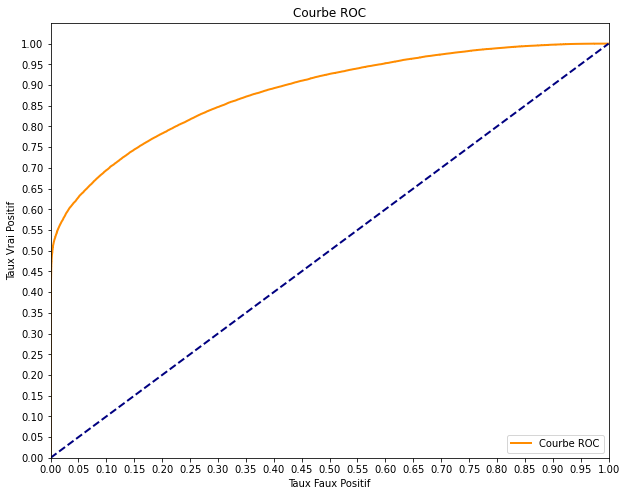

In [38]:
y_score = grid_cb.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC:', round(auc(fpr, tpr),5))

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Courbe ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('Taux Faux Positif')
plt.ylabel('Taux Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Conclusion
<hr style="border-width:2px;border-color:limegreen">

>Pour finir, voici un comparatif des différents modèles que nous avons testés et observés.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


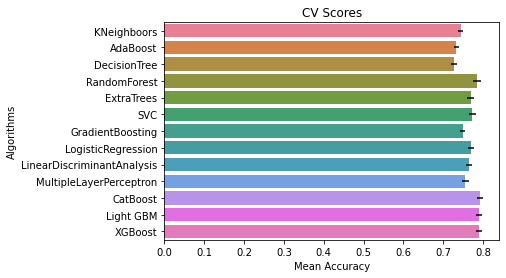

In [39]:
K_fold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2

models = [] # append all models or predictive models 
cv_results = [] # cross validation result
cv_means = [] # cross validation mean value
cv_std = [] # cross validation standard deviation

models.append(KNeighborsClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(SVC(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(LogisticRegression(random_state = random_state))
models.append(LinearDiscriminantAnalysis())
models.append(MLPClassifier(random_state=random_state))
models.append(CatBoostClassifier(random_state=random_state))
models.append(LGBMClassifier(random_state=random_state))
models.append(XGBClassifier(random_state=random_state))

for model in models :
    cv_results.append(cross_val_score(model, X_train_scaled, y_train, 
                                      scoring = "accuracy", cv = K_fold, n_jobs=-1))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_frame = pd.DataFrame(
    {
        "CrossValMeans":cv_means,
        "CrossValErrors": cv_std,
        "Algorithms":[
                     "KNeighboors",
                     "AdaBoost", 
                     "DecisionTree",   
                     "RandomForest",
                     "ExtraTrees",
                     "SVC",
                     "GradientBoosting",                      
                     "LogisticRegression",
                     "LinearDiscriminantAnalysis",
                     "MultipleLayerPerceptron",
                     "CatBoost",
                     "Light GBM",
                     "XGBoost"]
    })

cv_plot = sns.barplot("CrossValMeans","Algorithms", data = cv_frame,
                palette="husl", orient = "h", **{'xerr':cv_std})

cv_plot.set_xlabel("Mean Accuracy")
cv_plot = cv_plot.set_title("CV Scores")

>L'ensemble des modèles que nous avons testés ont un **score supérieur à 70%.** <br><br>
Il est assez simple d'atteindre un "score accuracy" supérieure à 70%. L'ajustement des variables nous permet d'augmenter ce dernier de quelques points.
Le modèle le plus performant est le modèle **CatBoostClassifier** qui délivre un score de **79%**.
> Nous avons constaté que les modèles sont plus fiables pour trouver les vrais positifs que les vrais négatifs. Ce léger biais est dû à des données légèrement déséquilibrées.<br><br>
>Nous avons constaté que ce dernier modèle est aussi celui le moins interprétable.
Notre but étant d'aider les créateurs à adapter au mieux leur projet, il serait intéressant de disposer d'un modèle relativement interprétable pour faciliter la prise de décision. Un modèle hybride (mix entre deux modèles) serait une bonne option pour atteindre notre objectif : celui de mieux orienter les entrepreneurs dans la création de leur campagne sur la plateforme Kickstarter. 
> Nous pensons que pour améliorer nos modèles Machine Learning, nous pourrions :
> - Ajouter des informations extérieures :  tendances Google, le budget des campagnes marketing, webscrapping (description longue, mise en avant sur le site...).
> - Affiner la sélection des features pour exclure les variables non siginificatives.